In [626]:
import collections
import math
from io import StringIO

import numpy as np
import pandas as pd
import pydotplus  # pip install pydotplus
import seaborn as sns
from ipywidgets import Image
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10, 8)

In [627]:
# Create dataframe with dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis=1)
    out.drop(feature_list, axis=1, inplace=True)
    return out


# Some feature values are present in train and absent in test and vice-versa.
def intersect_features(train, test):
    common_feat = list(set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [628]:
features = ["Looks", "Alcoholic_beverage", "Eloquence", "Money_spent"]

In [629]:
df_train = {}
df_train["Looks"] = [
    "handsome",
    "handsome",
    "handsome",
    "repulsive",
    "repulsive",
    "repulsive",
    "handsome",
]
df_train["Alcoholic_beverage"] = ["yes", "yes", "no", "no", "yes", "yes", "yes"]
df_train["Eloquence"] = ["high", "low", "average", "average", "low", "high", "average"]
df_train["Money_spent"] = ["lots", "little", "lots", "little", "lots", "lots", "lots"]
df_train["Will_go"] = LabelEncoder().fit_transform(["+", "-", "+", "-", "-", "+", "+"])

df_train = create_df(df_train, features)
df_train

,Will_go,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Eloquence_low,Money_spent_little,Money_spent_lots
0,0,True,False,False,True,False,True,False,False,True
1,1,True,False,False,True,False,False,True,True,False
2,0,True,False,True,False,True,False,False,False,True
3,1,False,True,True,False,True,False,False,True,False
4,1,False,True,False,True,False,False,True,False,True
5,0,False,True,False,True,False,True,False,False,True
6,0,True,False,False,True,True,False,False,False,True


In [630]:
df_test = {}
df_test["Looks"] = ["handsome", "handsome", "repulsive"]
df_test["Alcoholic_beverage"] = ["no", "yes", "yes"]
df_test["Eloquence"] = ["average", "high", "average"]
df_test["Money_spent"] = ["lots", "little", "lots"]
df_test = create_df(df_test, features)
df_test

,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Money_spent_little,Money_spent_lots
0,True,False,True,False,True,False,False,True
1,True,False,False,True,False,True,True,False
2,False,True,False,True,True,False,False,True


In [631]:
# Some feature values are present in train and absent in test and vice-versa.
y = df_train["Will_go"]
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Looks_repulsive,Money_spent_lots,Money_spent_little,Eloquence_high,Eloquence_average,Alcoholic_beverage_no,Alcoholic_beverage_yes,Looks_handsome
0,False,True,False,True,False,False,True,True
1,False,False,True,False,False,False,True,True
2,False,True,False,False,True,True,False,True
3,True,False,True,False,True,True,False,False
4,True,True,False,False,False,False,True,False
5,True,True,False,True,False,False,True,False
6,False,True,False,False,True,False,True,True


In [632]:
y

0    0
1    1
2    0
3    1
4    1
5    0
6    0
Name: Will_go, dtype: int64

[Text(0.6, 0.875, 'Money_spent_little <= 0.5\nentropy = 0.985\nsamples = 7\nvalue = [4, 3]\nclass = True'),
 Text(0.4, 0.625, 'Looks_repulsive <= 0.5\nentropy = 0.722\nsamples = 5\nvalue = [4, 1]\nclass = True'),
 Text(0.2, 0.375, 'entropy = 0.0\nsamples = 3\nvalue = [3, 0]\nclass = True'),
 Text(0.6, 0.375, 'Eloquence_high <= 0.5\nentropy = 1.0\nsamples = 2\nvalue = [1, 1]\nclass = True'),
 Text(0.4, 0.125, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = False'),
 Text(0.8, 0.125, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = True'),
 Text(0.8, 0.625, 'entropy = 0.0\nsamples = 2\nvalue = [0, 2]\nclass = False')]

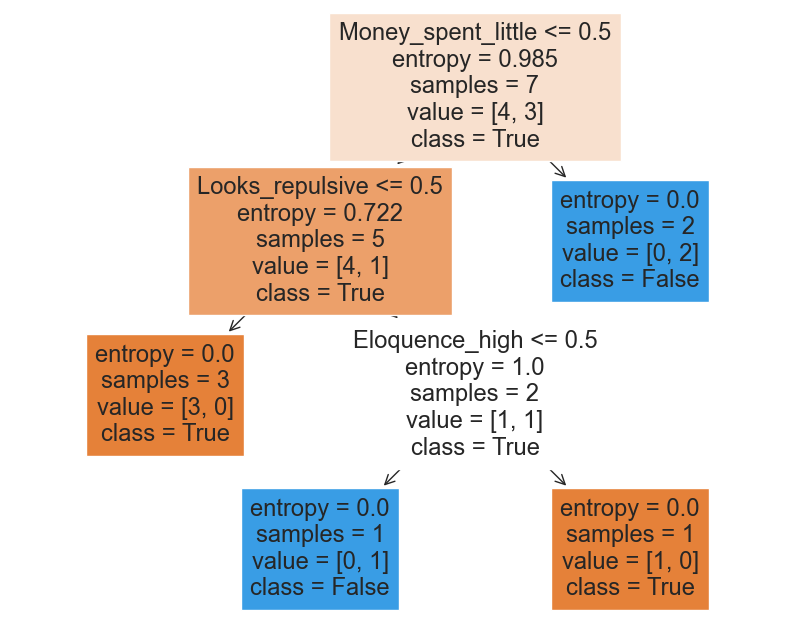

In [633]:
tree_class = DecisionTreeClassifier(criterion="entropy", random_state=17)

tree_class.fit(df_train, y)

plot_tree(tree_class, feature_names=df_train.columns, filled=True, class_names=["True", "False"])

In [634]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

In [635]:
# two groups
balls_left = [1 for i in range(8)] + [0 for i in range(5)]  # 8 blue and 5 yellow
balls_right = [1 for i in range(1)] + [0 for i in range(6)]  # 1 blue and 6 yellow

In [636]:
from collections import Counter


def entropy(a_list):
    label_counts = Counter(a_list)
    entropy = 0
    for label in label_counts.values():
        entropy -= label/len(a_list)*math.log2((label/len(a_list)))
    return entropy

In [637]:
print(entropy(balls))  # 9 blue и 11 yellow
print(entropy(balls_left))  # 8 blue и 5 yellow
print(entropy(balls_right))  # 1 blue и 6 yellow
print(entropy([1, 2, 3, 4, 5, 6]))  # entropy of a fair 6-sided die

0.9927744539878083
0.9612366047228759
0.5916727785823275
2.584962500721156


In [638]:
# information gain calculation
def information_gain(root, left, right):
    """ root - initial data, left and right - two partitions of initial data"""
    return (
        entropy(root)
        - 1.0* len(left)/len(root)*entropy(left)
        - 1.0* len(right)/len(root)*entropy(right)
    )

In [639]:
print(information_gain(balls, balls_left, balls_right))

0.16088518841412436


In [640]:
def information_gains(X, y):
    """Outputs information gain when splitting with each feature"""
    output = []
    for i in X.columns:
        output.append(information_gain(y, y[X[i]==0], y[X[i]==1]))
    return output

In [641]:
information_gains(df_train, y)

[0.12808527889139443,
 0.46956521111470695,
 0.46956521111470695,
 0.2916919971380597,
 0.020244207153756077,
 0.0059777114237740125,
 0.0059777114237740125,
 0.12808527889139443]

In [642]:
def btree(X, y, feature_names):
    clf = information_gains(X, y)
    best_feature_id = clf.index(max(clf))
    best_feature_name = feature_names[best_feature_id]
    print(f'Best feature name {best_feature_name}')
    
    x_left = X[X.iloc[:, best_feature_id]==0]
    x_right= X[X.iloc[:, best_feature_id]==1]

    y_left = y[X.iloc[:, best_feature_id]==0]
    y_right= y[X.iloc[:, best_feature_id]==1]
    
    entropy_left = entropy(y_left)
    entropy_right = entropy(y_right)
    
    if entropy_left!=0:
        print(f"Splitting the left group. {len(x_left)} samples.")
        btree(x_left, y_left, feature_names)
    if entropy_right!=0:
        print(f"Splitting the right group. {len(x_right)} samples.")
        btree(x_right, y_right, feature_names)
    

In [643]:
btree(df_train, y, df_train.columns)

Best feature name Money_spent_lots
Splitting the right group. 5 samples.
Best feature name Looks_repulsive
Splitting the right group. 2 samples.
Best feature name Eloquence_high


In [644]:
data_path = '../mlcourse.ai_Dataset/'

data_train = pd.read_csv(data_path+'adult_train.csv')
data_test = pd.read_csv(data_path+'adult_test.csv')

In [645]:
data_train.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [646]:
data_test.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.
16281,35,Self-emp-inc,182148.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K.


In [647]:
# necessary to remove rows with incorrect labels in test dataset
data_test = data_test[
    (data_test["Target"] == " >50K.") | (data_test["Target"] == " <=50K.")
    ]

# encode target variable as integer
data_train.loc[data_train["Target"] == " <=50K", "Target"] = 0
data_train.loc[data_train["Target"] == " >50K", "Target"] = 1

data_test.loc[data_test["Target"] == " <=50K.", "Target"] = 0
data_test.loc[data_test["Target"] == " >50K.", "Target"] = 1

In [648]:
data_test.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281.0,NaN,NaN,NaN,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281.0,NaN,NaN,NaN,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [649]:
data_train["Target"].value_counts()

Target
0    24720
1     7841
Name: count, dtype: int64

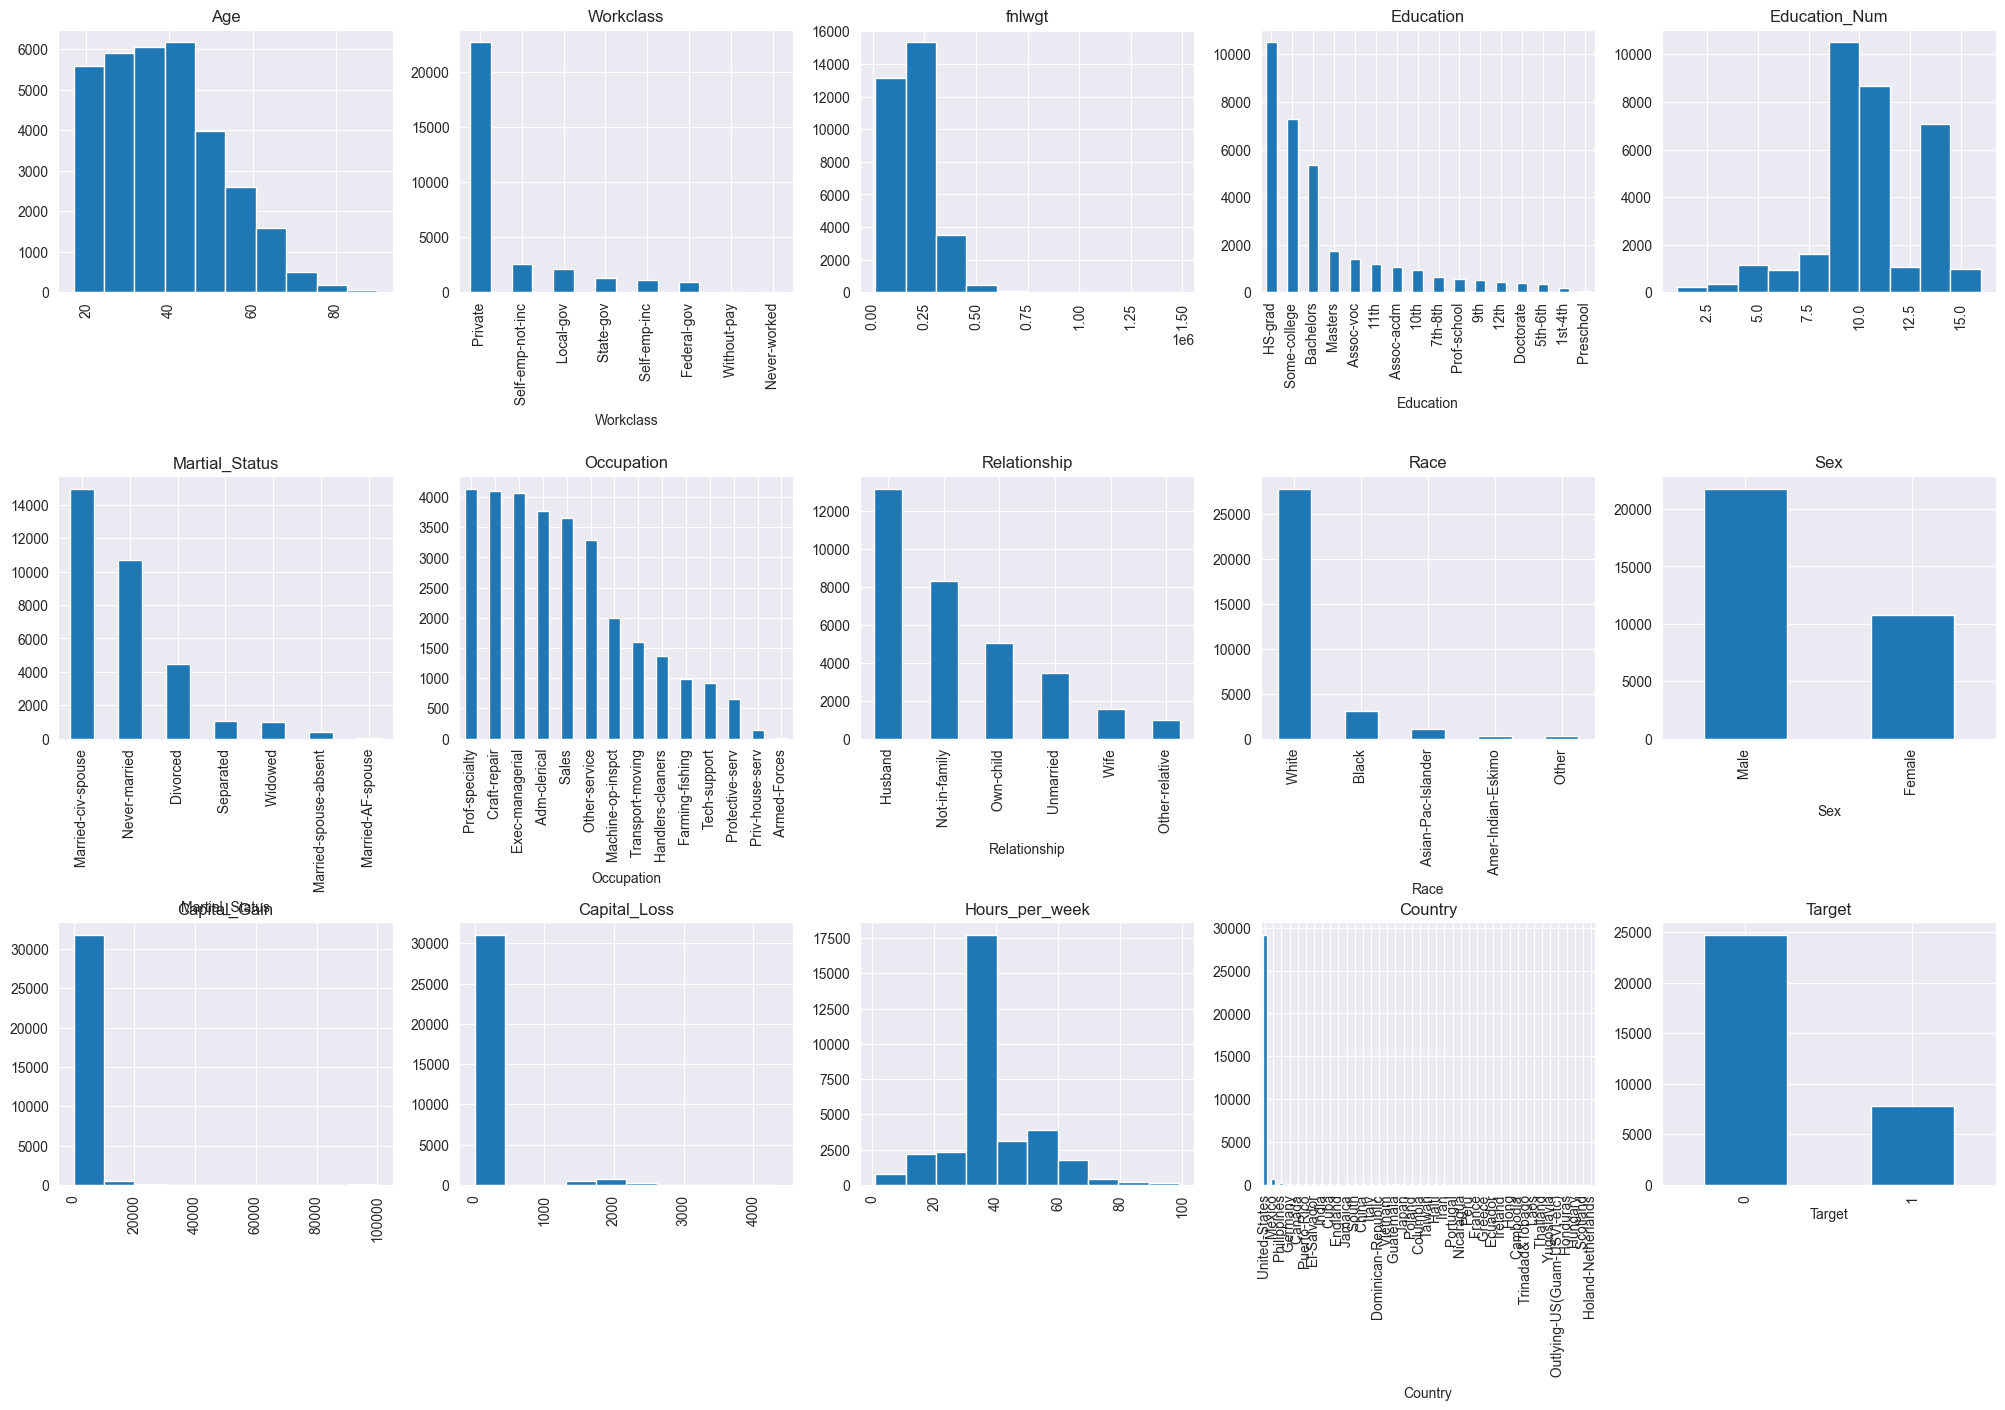

In [650]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = int(data_train.shape[1] / cols)
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2);

In [651]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

In [652]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target             object
dtype: object

In [653]:
data_test["Age"] = data_test["Age"].astype(int)
data_test["fnlwgt"] = data_test["fnlwgt"].astype(int)
data_test["Education_Num"] = data_test["Education_Num"].astype(int)
data_test["Capital_Gain"] = data_test["Capital_Gain"].astype(int)
data_test["Capital_Loss"] = data_test["Capital_Loss"].astype(int)
data_test["Hours_per_week"] = data_test["Hours_per_week"].astype(int)

# same for the target
data_train["Target"] = data_train["Target"].astype(int)
data_test["Target"] = data_test["Target"].astype(int)

In [654]:
y_train = data_train.pop('Target')
y_test = data_test.pop('Target')

In [655]:
# choose categorical and continuous features from data

categorical_columns = [
    c for c in data_train.columns if data_train[c].dtype.name == "object"
]
numerical_columns = [
    c for c in data_train.columns if data_train[c].dtype.name != "object"
]

print("categorical_columns:", categorical_columns)
print("numerical_columns:", numerical_columns)

categorical_columns: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
numerical_columns: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']


In [656]:
# fill missing data

for c in categorical_columns:
    data_train[c].fillna(data_train[c].mode()[0], inplace=True)
    data_test[c].fillna(data_train[c].mode()[0], inplace=True)

for c in numerical_columns:
    data_train[c].fillna(data_train[c].median(), inplace=True)
    data_test[c].fillna(data_train[c].median(), inplace=True)

C:\Users\Vitalij\AppData\Local\Temp\ipykernel_5616\2158582940.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_train[c].fillna(data_train[c].mode()[0], inplace=True)
C:\Users\Vitalij\AppData\Local\Temp\ipykernel_5616\2158582940.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c

In [657]:
data_train = pd.concat(
    [data_train[numerical_columns], pd.get_dummies(data_train[categorical_columns])],
    axis=1,
)

data_test = pd.concat(
    [data_test[numerical_columns], pd.get_dummies(data_test[categorical_columns])],
    axis=1,
)

In [658]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [659]:
data_train.shape, data_test.shape

((32561, 105), (16281, 104))

In [660]:
data_test["Country_ Holand-Netherlands"] = 0
set(data_train.columns) - set(data_test.columns)

set()

In [661]:
X_train = data_train
X_test = data_test

In [662]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=17)

In [663]:
tree_predictions = tree.predict(X_test[X_train.columns])

In [664]:
accuracy_score(y_test, tree_predictions)

0.8447884036607088

In [665]:
tree_params = {"max_depth": range(2, 11)}

locally_best_tree = GridSearchCV(estimator=DecisionTreeClassifier(random_state=17), param_grid=tree_params, cv=5, n_jobs=-1)  
locally_best_tree.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=17), n_jobs=-1,
             param_grid={'max_depth': range(2, 11)})

In [666]:
print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score", locally_best_tree.best_score_)

Best params: {'max_depth': 9}
Best cross validaton score 0.8565770273854106


In [667]:
tuned_tree = DecisionTreeClassifier(max_depth=9, random_state=17)
tuned_tree.fit(X_train, y_train)
tuned_tree_predictions = tuned_tree.predict(X_test[X_train.columns])
accuracy_score(y_test, tuned_tree_predictions)

0.8579939807137154

In [668]:
rf = RandomForestClassifier(random_state=17, n_estimators=100)
rf.fit(X_train, y_train)

rf_predictions = rf.predict(X_test[X_train.columns])
accuracy_score(y_test, rf_predictions)

0.8525274860266568

In [670]:
forest_params = {'max_depth': range(10, 21),
                'max_features': range(5, 105, 20)}

locally_best_forest = GridSearchCV(estimator=RandomForestClassifier(random_state=17), param_grid=forest_params, n_jobs=-1) 
locally_best_forest.fit(X_train, y_train)
locally_best_pred = locally_best_tree.predict(X_test[X_train.columns])
accuracy_score(y_test, locally_best_pred)

KeyboardInterrupt: 